Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import GitHub repository

In [2]:
import os

if not os.path.isdir('tanogan'):
  !git clone https://github.com/sergiuabed/tanogan
else:
  %cd tanogan/
  !git pull
  %cd ..

Cloning into 'tanogan'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 41 (delta 18), reused 34 (delta 11), pack-reused 0
Receiving objects: 100% (41/41), 8.43 KiB | 4.21 MiB/s, done.
Resolving deltas: 100% (18/18), done.


# Imports

In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import pickle
import datetime
from sklearn.model_selection import train_test_split
from tanogan.data_utils.data_utils import get_df_action, get_standardizer, standardization
from tanogan.architecture import init_generator, init_discriminator, init_encoder
from tanogan.training import adversarial_training

# Load Dataset
Load dataset locally from Google Drive

The dataset comes from a SWaT testbed, specifically on the physical properties.

In [4]:
if not os.path.isdir('SWaT_physical_2015'):
  !cp -R /content/drive/MyDrive/ml-applications/TimeSeriesAnomalyDetection_project/SWaT_physical_2015/ .

path = './SWaT_physical_2015'

if os.path.isfile(path + '/normal_and_attacked_dfs.h5'):
  store = pd.HDFStore(path + '/normal_and_attacked_dfs.h5')

  df_normal = store['df_normal']
  normal_labels = store['normal_labels']
  df_attack = store['df_attack']
  attack_labels = store['attack_labels']
else:
  # Load normal (non-anomalous) data
  filepath_xlsx_normal = path + '/SWaT_Dataset_Normal_v1.xlsx'
  df_normal = pd.read_excel(filepath_xlsx_normal)

  column_names = df_normal.iloc[0].copy() #first row contains the names of the columns
  df_normal = df_normal.iloc[1:]  #drop first row

  df_normal.columns = column_names  #assign column names
  df_normal.index = df_normal[' Timestamp'].copy()

  df_normal.drop(" Timestamp", axis=1, inplace=True)

  # Load anomalous data
  filepath_xlsx_attack = path + '/SWaT_Dataset_Attack_v0.xlsx'
  df_attack = pd.read_excel(filepath_xlsx_attack)

  column_names = df_attack.iloc[0].copy() #first row contains the names of the columns
  df_attack = df_attack.iloc[1:]  #drop first row

  df_attack.columns = column_names  #assign column names
  df_attack.index = df_attack[' Timestamp'].copy()

  df_attack.drop(" Timestamp", axis=1, inplace=True)

  # Split labels from data
  normal_labels = df_normal['Normal/Attack']
  normal_labels = pd.Series([0 if l == 'Normal' else 1 for l in normal_labels])

  attack_labels = df_attack['Normal/Attack']
  attack_labels = pd.Series([0 if l == 'Normal' else 1 for l in attack_labels])

  df_normal.drop('Normal/Attack', axis=1, inplace=True)
  df_attack.drop('Normal/Attack', axis=1, inplace=True)

  # Cast columns datatype to float
  df_normal = df_normal.apply(pd.to_numeric)
  df_attack = df_attack.apply(pd.to_numeric)

  # Remove blank characters from column names
  def remove_blank(string):
    return "".join(string.split())

  normal_cols = df_normal.columns.copy()
  attack_cols = df_attack.columns.copy()

  normal_cols2 = [remove_blank(c) for c in normal_cols]
  attack_cols2 = [remove_blank(c) for c in attack_cols]

  map_n = {i: j for (i, j) in zip(normal_cols, normal_cols2)}
  map_a = {i: j for (i, j) in zip(attack_cols, attack_cols2)}

  df_normal.rename(columns=map_n, inplace=True)
  df_attack.rename(columns=map_a, inplace=True)

In [5]:
df_normal.head(10)

,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,MV201,...,FIT504,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603
Timestamp,,,,,,,,,,,,,,,,,,,,,
22/12/2015 4:30:00 PM,0.0,124.3135,1,1,1,251.9226,8.313446,312.7916,0.0,1,...,0.0,1,1,9.100231,0.0,3.3485,0.000256,1,1,1
22/12/2015 4:30:01 PM,0.0,124.3920,1,1,1,251.9226,8.313446,312.7916,0.0,1,...,0.0,1,1,9.100231,0.0,3.3485,0.000256,1,1,1
22/12/2015 4:30:02 PM,0.0,124.4705,1,1,1,251.9226,8.313446,312.7916,0.0,1,...,0.0,1,1,9.100231,0.0,3.3485,0.000256,1,1,1
22/12/2015 4:30:03 PM,0.0,124.6668,1,1,1,251.9226,8.313446,312.7916,0.0,1,...,0.0,1,1,9.100231,0.0,3.3485,0.000256,1,1,1
22/12/2015 4:30:04 PM,0.0,124.5098,1,1,1,251.9226,8.313446,312.7916,0.0,1,...,0.0,1,1,9.100231,0.0,3.3485,0.000256,1,1,1
22/12/2015 4:30:05 PM,0.0,123.9210,1,1,1,251.9226,8.313446,312.7916,0.0,1,...,0.0,1,1,9.100231,0.0,3.3485,0.000256,1,1,1
22/12/2015 4:30:06 PM,0.0,123.5284,1,1,1,251.9226,8.313446,312.7916,0.0,1,...,0.0,1,1,9.100231,0.0,3.3485,0.000256,1,1,1
22/12/2015 4:30:07 PM,0.0,123.4107,1,1,1,251.9226,8.313446,312.7916,0.0,1,...,0.0,1,1,9.100231,0.0,3.3485,0.000256,1,1,1
22/12/2015 4:30:08 PM,0.0,123.2144,1,1,1,251.9226,8.312805,312.7916,0.0,1,...,0.0,1,1,9.100231,0.0,3.3485,0.000256,1,1,1


## Suggestion:
Loading data from excel files in dataframes is very slow. To avoid doing this everytime you need to execute this notebook, save the dataframes in secondary memory using HDF5.

To save the dataframes, run the following cell.

In [6]:
if not os.path.isfile(path + '/normal_and_attacked_dfs.h5'):
  #store = pd.HDFStore('normal_and_attacked_dfs.h5')
  #store['df_normal'] = df_normal
  #store['normal_labels'] = normal_labels
  #store['df_attack'] = df_attack
  #store['attack_labels'] = attack_labels

  df_normal.to_hdf('normal_and_attacked_dfs.h5', key='df_normal')
  normal_labels.to_hdf('normal_and_attacked_dfs.h5', key='normal_labels')
  df_attack.to_hdf('normal_and_attacked_dfs.h5', key='df_attack')
  attack_labels.to_hdf('normal_and_attacked_dfs.h5', key='attack_labels')

  # copy file 'normal_and_attacked_dfs.h5' to Drive
  !cp ./normal_and_attacked_dfs.h5 /content/drive/MyDrive/ml-applications/TimeSeriesAnomalyDetection_project/SWaT_physical_2015/

# Data Preprocessing

Standardize the data

In [7]:
# standardize data
standardizer = get_standardizer(df_normal)

df_normal = standardization(df_normal, standardizer)
df_attack = standardization(df_attack, standardizer)

In [8]:
df_attack.head(10)

,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,MV201,...,FIT504,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603
Timestamp,,,,,,,,,,,,,,,,,,,,,
28/12/2015 10:00:00 AM,0.509078,-0.531668,0.610641,0.57866,0.0,-0.369209,0.091710,-0.399305,0.577082,0.571882,...,0.030545,0.055828,0.0,-0.067305,2.260671,-0.125269,-0.096008,0.0,-0.089482,0.0
28/12/2015 10:00:01 AM,0.526046,-0.531345,0.610641,0.57866,0.0,-0.369209,0.091710,-0.399305,0.577082,0.571882,...,0.030545,0.055828,0.0,-0.067305,2.260671,-0.117722,-0.096008,0.0,-0.089482,0.0
28/12/2015 10:00:02 AM,0.563942,-0.531668,0.610641,0.57866,0.0,-0.369209,0.070398,-0.399305,0.574180,0.571882,...,0.078364,0.055828,0.0,-0.066129,2.260671,-0.117722,-0.096008,0.0,-0.089482,0.0
28/12/2015 10:00:03 AM,0.603816,-0.530699,0.610641,0.57866,0.0,-0.369209,0.070398,-0.399305,0.574180,0.571882,...,0.078364,0.055828,0.0,-0.066129,2.260671,-0.123761,-0.096008,0.0,-0.089482,0.0
28/12/2015 10:00:04 AM,0.634641,-0.526505,0.610641,0.57866,0.0,-0.369209,0.070398,-0.399305,0.574906,0.571882,...,0.078364,0.055828,0.0,-0.066129,2.260671,-0.134322,-0.096008,0.0,-0.089482,0.0
28/12/2015 10:00:05 AM,0.669991,-0.523279,0.610641,0.57866,0.0,-0.369209,0.070398,-0.399305,0.575873,0.571882,...,0.078364,0.055828,0.0,-0.075555,2.260671,-0.134322,-0.096008,0.0,-0.089482,0.0
28/12/2015 10:00:06 AM,0.694595,-0.521344,0.610641,0.57866,0.0,-0.369209,0.070398,-0.399305,0.575873,0.571882,...,0.078364,0.055828,0.0,-0.087333,2.260671,-0.134322,-0.096008,0.0,-0.089482,0.0
28/12/2015 10:00:07 AM,0.707886,-0.520375,0.610641,0.57866,0.0,-0.369209,0.070398,-0.399305,0.573695,0.571882,...,0.078364,0.055828,0.0,-0.087333,2.260671,-0.134322,-0.096008,0.0,-0.089482,0.0
28/12/2015 10:00:08 AM,0.710998,-0.518117,0.610641,0.57866,0.0,-0.369209,0.070398,-0.399305,0.573695,0.571882,...,0.078364,0.055828,0.0,-0.063776,2.260671,-0.134322,-0.096008,0.0,-0.089482,0.0


# Hyperparameters

In [9]:
DATASET_FREQUENCY = 10 #Hz
WINDOW_TIME = 10#6 #seconds
WINDOW_SIZE = 10 # nr of samples in a window
SAMPLE_SIZE = 51
LATENT_VAR_SIZE = 32 #SAMPLE_SIZE
TRAIN_BATCH_SIZE = 32
TEST_BATCH_SIZE = 1
EPOCHS = 10
LAMBDA = 0.1

training_loss = tf.keras.losses.BinaryCrossentropy()

discr_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)
gen_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)

Set the same index from dataframes to series containing the labels

In [10]:
normal_labels.index = df_normal.index
attack_labels.index = df_attack.index

In [11]:
#df_normall = df_normal.copy()
#df_normall.insert(0, 'anomaly', normal_labels)

df_normal.insert(0, 'anomaly', normal_labels)
df_attack.insert(0, 'anomaly', attack_labels)

## Window the data

In [12]:
def window_data(df, window_size, shift=1): # window_size refers to the nr of samples in a window
  df.sort_index(inplace=True)
  #df.index = [i for i in range(len(df.index))]

  windows_list = []
  label_list = []

  for i in range(0, len(df.index), shift):
    if i + window_size <= len(df.index):
      window = df.iloc[i : i + window_size].copy()

      nr_anomalies = window['anomaly'].sum()

      if nr_anomalies > 0:
        #print(f"This happened! nr_anomalies={nr_anomalies}")
        label_list.append(1)
      else:
        label_list.append(0)

      window = window.drop(["anomaly"], axis=1).to_numpy()

      windows_list.append(window)
      #print(len(windows_list))

  return np.array(windows_list), np.array(label_list)
  #return windows_list, label_list

In [13]:
#windows_normal, labels_normal = window_data(df_normal, WINDOW_SIZE, 1)
windows_attack, labels_attack = window_data(df_attack, WINDOW_SIZE, WINDOW_SIZE)

In [14]:
print(f"Nr samples in df_normal: {df_normal.shape}")
print(f"Nr of windows in windows_normal: {windows_normal.shape}\n")

print(f"Nr of anomalous windows in windows_regular: {windows_normal[labels_normal==1].shape[0]}")

Nr samples in df_normal: (495000, 52)


NameError: ignored

In [ ]:
#overlapped_windows_rec1, overlapped_labels_rec1 = window_data(df_rec1_labelled, WINDOW_SIZE, 1)
#overlapped_windows_rec5, overlapped_labels_rec5 = window_data(df_rec5_labelled, WINDOW_SIZE, 1)

del df_normal, df_attack, normal_labels, attack_labels

# Dataset

Make TensorFlow Dataset

In [ ]:
#train_dataset = tf.data.Dataset.from_tensor_slices((windows_normal, labels_normal)).map(lambda x, y: (tf.cast(x, tf.float32), y)).batch(TRAIN_BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((windows_attack, labels_attack)).map(lambda x, y: (tf.cast(x, tf.float32), y)).batch(TEST_BATCH_SIZE)

#validation_dataset = tf.data.Dataset.from_tensor_slices((windows_rec5, labels_rec5)).map(lambda x, y: (tf.cast(x, tf.float32), y)).batch(TEST_BATCH_SIZE)
#test_dataset = tf.data.Dataset.from_tensor_slices((windows_rec1, labels_rec1)).map(lambda x, y: (tf.cast(x, tf.float32), y)).batch(TEST_BATCH_SIZE)

# Generator and Discriminator instantiation

In [ ]:
generator = init_generator(in_dim=(WINDOW_SIZE, LATENT_VAR_SIZE), out_dim=(WINDOW_SIZE, SAMPLE_SIZE))
discriminator = init_discriminator(in_dim=(WINDOW_SIZE, SAMPLE_SIZE), out_dim=1)

# Training

In [ ]:
def adversarial_training(generator, discriminator, data, batch_size, windows_size, latent_size, loss_fn, discr_optimizer, gen_optimizer, checkpoints_backup_path, num_epochs=1):

# setup checkpoint saving
  directory_path = "./checkpoints"

  filepath_generator = directory_path + "/generator/"
  filepath_discriminator = directory_path + "/discriminator/"

  if not os.path.isdir('checkpoints'):
    ! mkdir checkpoints

    ! mkdir {filepath_generator}
    ! mkdir {filepath_discriminator}

  real_label = 0
  fake_label = 1

  print("epoch: 0/%d")
  for epoch in range(num_epochs):
    for i, (time_sequences, labels) in enumerate(data):
      # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))

      #Train with real data
      with tf.GradientTape() as tape:
        scores = discriminator(time_sequences)
        discr_real_loss = loss_fn(labels, scores)

      gradients = tape.gradient(discr_real_loss, discriminator.trainable_weights)
      discr_optimizer.apply_gradients(zip(gradients, discriminator.trainable_weights))

      #Train with fake data
      noise = tf.random.normal((time_sequences.shape[0], time_sequences.shape[1], latent_size), mean=0, stddev=1)
      fake_sequences = generator(noise)
      fake_labels = tf.ones(labels.shape) * fake_label

      with tf.GradientTape() as tape:
          scores = discriminator(fake_sequences)
          discr_fake_loss = loss_fn(fake_labels, scores)

      gradients = tape.gradient(discr_fake_loss, discriminator.trainable_weights)
      discr_optimizer.apply_gradients(zip(gradients, discriminator.trainable_weights))


      # (2) Update G network: maximize log(D(G(z)))

      noise = tf.random.normal((time_sequences.shape[0], time_sequences.shape[1], latent_size), mean=0, stddev=1)
      with tf.GradientTape() as tape:
        fake_sequences = generator(noise)
        #real_labels = tf.ones(noise.shape)
        discriminator_output = discriminator(fake_sequences)    # discriminator tells which fake sequences it considers to be real and which not
        generator_loss = loss_fn(labels, discriminator_output)

      gradients = tape.gradient(generator_loss, generator.trainable_weights)
      gen_optimizer.apply_gradients(zip(gradients, generator.trainable_weights))

      print(
          f"epoch: {epoch}/{num_epochs},    batch: {i}/{len(data)}    Discriminator_loss: {discr_real_loss+discr_fake_loss}  Generator_loss: {generator_loss}"
      )

    generator.save_weights(filepath_generator + f"gen_epoch{epoch}.h5")
    discriminator.save_weights(filepath_discriminator + f"discr_epoch{epoch}.h5")

    # zip and move a copy of the checkpoints
    now = datetime.datetime.now()
    zip_name = f"checkpoints_{str(now.date())+'_'+str(now.time())}.zip"

    !zip -r {zip_name} ./checkpoints
    !cp {zip_name} {checkpoints_backup_path}

#    gen_symbolic_weights = getattr(gen_optimizer, 'weights')  # save gen_optimizer parameters
#    weight_values = K.batch_get_value(gen_symbolic_weights)
#    with open(f'checkpoints/generator/gen_optimizer_epoch{epoch}.pkl', 'wb') as f:
#      pickle.dump(weight_values, f)
#
#    discr_symbolic_weights = getattr(discr_optimizer, 'weights')  # save discr_optimizer parameters
#    weight_values = K.batch_get_value(discr_symbolic_weights)
#    with open(f'checkpoints/discriminator/discr_optimizer_epoch{epoch}.pkl', 'wb') as f:
#      pickle.dump(weight_values, f)

In [ ]:
adversarial_training(generator, discriminator, train_dataset, TRAIN_BATCH_SIZE, WINDOW_SIZE, LATENT_VAR_SIZE, training_loss, discr_optimizer, gen_optimizer, "./drive/MyDrive/ml-applications/TimeSeriesAnomalyDetection_project/saved_checkpoints_swat", 10)

epoch: 0/%d


Streaming output truncated to the last 5000 lines.
epoch: 9/10,    batch: 10492/15469    Discriminator_loss: 0.24244047701358795  Generator_loss: 1.5787270069122314
epoch: 9/10,    batch: 10493/15469    Discriminator_loss: 0.23584099113941193  Generator_loss: 1.5746498107910156
epoch: 9/10,    batch: 10494/15469    Discriminator_loss: 0.2338649034500122  Generator_loss: 1.5717999935150146
epoch: 9/10,    batch: 10495/15469    Discriminator_loss: 0.23487521708011627  Generator_loss: 1.5708661079406738
epoch: 9/10,    batch: 10496/15469    Discriminator_loss: 0.23499156534671783  Generator_loss: 1.5680882930755615
epoch: 9/10,    batch: 10497/15469    Discriminator_loss: 0.23471951484680176  Generator_loss: 1.5674941539764404
epoch: 9/10,    batch: 10498/15469    Discriminator_loss: 0.2345684915781021  Generator_loss: 1.5682694911956787
epoch: 9/10,    batch: 10499/15469    Discriminator_loss: 0.2347453385591507  Generator_loss: 1.5691386461257935
epoch: 9/10,    batch: 10500/15469    Di

# Encoder Training

In [ ]:
def encoder_training(encoder, generator, data, latent_size, checkpoints_backup_path, num_epochs=1):
  '''
  Encoder must be trained on regular data only.

  The purpose of the encoder is to learn the inverse mapping of the generator,
  i.e. how to map a time sequence to the latent space.
  '''

  # setup checkpoint saving
  directory_path = "./encoder_checkpoints"

  if not os.path.isdir('encoder_checkpoints'):
    ! mkdir encoder_checkpoints

  loss_fn = tf.keras.losses.MeanAbsoluteError()
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)

  print("epoch: 0/%d")
  for epoch in range(3, num_epochs):
    sum_loss = 0
    for i, (time_sequences, labels) in enumerate(data):
      with tf.GradientTape() as tape:
        latent_output = encoder(time_sequences)
        generated_seq = generator(latent_output)

        enc_loss = loss_fn(time_sequences, generated_seq)

      gradients = tape.gradient(enc_loss, encoder.trainable_weights)
      optimizer.apply_gradients(zip(gradients, encoder.trainable_weights))

      sum_loss += enc_loss

      print(
        f"  epoch: {epoch}/{num_epochs},    batch: {i}/{len(data)}    Encoder_loss: {enc_loss}"
      )

    print(
      f"epoch: {epoch}/{num_epochs},  Tot_epoch_loss: {sum_loss}"
    )

    encoder.save_weights(directory_path + f"/encoder_epoch{epoch}.h5")

    now = datetime.datetime.now()
    zip_name = f"encoder_checkpoints_{str(now.date())+'_'+str(now.time())}.zip"

    !zip -r {zip_name} ./encoder_checkpoints
    !cp {zip_name} {checkpoints_backup_path}

## IMPORTANT: run this cell only if you want to load previously saved checkpoints for generator and discriminator.

In [ ]:
generator = init_generator(in_dim=(WINDOW_SIZE, LATENT_VAR_SIZE), out_dim=(WINDOW_SIZE, SAMPLE_SIZE))
discriminator = init_discriminator(in_dim=(WINDOW_SIZE, SAMPLE_SIZE), out_dim=1)

# download and uzip latest generator and discriminator checkpoints
!cp ./drive/MyDrive/ml-applications/TimeSeriesAnomalyDetection_project/saved_checkpoints_swat/checkpoints_2023-08-16_00:13:33.763024.zip .
!unzip ./checkpoints_2023-08-16_00:13:33.763024.zip -d .

epoch = 9
generator.load_weights(f"./checkpoints/generator/gen_epoch{epoch}.h5")
discriminator.load_weights(f"./checkpoints/discriminator/discr_epoch{epoch}.h5")

Archive:  ./checkpoints_2023-08-16_00:13:33.763024.zip
   creating: ./checkpoints/
   creating: ./checkpoints/generator/
  inflating: ./checkpoints/generator/gen_epoch3.h5  
  inflating: ./checkpoints/generator/gen_epoch9.h5  
  inflating: ./checkpoints/generator/gen_epoch1.h5  
  inflating: ./checkpoints/generator/gen_epoch2.h5  
  inflating: ./checkpoints/generator/gen_epoch5.h5  
  inflating: ./checkpoints/generator/gen_epoch4.h5  
  inflating: ./checkpoints/generator/gen_epoch0.h5  
  inflating: ./checkpoints/generator/gen_epoch7.h5  
  inflating: ./checkpoints/generator/gen_epoch8.h5  
  inflating: ./checkpoints/generator/gen_epoch6.h5  
   creating: ./checkpoints/discriminator/
  inflating: ./checkpoints/discriminator/discr_epoch2.h5  
  inflating: ./checkpoints/discriminator/discr_epoch8.h5  
  inflating: ./checkpoints/discriminator/discr_epoch4.h5  
  inflating: ./checkpoints/discriminator/discr_epoch9.h5  
  inflating: ./checkpoints/discriminator/discr_epoch6.h5  
  inflating:

## Start Encoder Training

In [ ]:
# init encoder
encoder = init_encoder(in_dim=(WINDOW_SIZE, SAMPLE_SIZE), out_dim=(WINDOW_SIZE, LATENT_VAR_SIZE))
encoder_training(encoder, generator, train_dataset, LATENT_VAR_SIZE, "./drive/MyDrive/ml-applications/TimeSeriesAnomalyDetection_project/saved_encoder_checkpoints_swat", num_epochs=10)

epoch: 0/%d


Streaming output truncated to the last 5000 lines.
  epoch: 9/10,    batch: 10481/15469    Encoder_loss: 0.3253931999206543
  epoch: 9/10,    batch: 10482/15469    Encoder_loss: 0.3244699537754059
  epoch: 9/10,    batch: 10483/15469    Encoder_loss: 0.3230203092098236
  epoch: 9/10,    batch: 10484/15469    Encoder_loss: 0.32254114747047424
  epoch: 9/10,    batch: 10485/15469    Encoder_loss: 0.32126784324645996
  epoch: 9/10,    batch: 10486/15469    Encoder_loss: 0.3221737742424011
  epoch: 9/10,    batch: 10487/15469    Encoder_loss: 0.321905255317688
  epoch: 9/10,    batch: 10488/15469    Encoder_loss: 0.3201863765716553
  epoch: 9/10,    batch: 10489/15469    Encoder_loss: 0.31932350993156433
  epoch: 9/10,    batch: 10490/15469    Encoder_loss: 0.318231463432312
  epoch: 9/10,    batch: 10491/15469    Encoder_loss: 0.3177185654640198
  epoch: 9/10,    batch: 10492/15469    Encoder_loss: 0.3175451159477234
  epoch: 9/10,    batch: 10493/15469    Encoder_loss: 0.3193942010402679

# Anomaly Detection

In [ ]:
def reconstruction_loss(time_sequences, fake_sequences, discriminator, _lambda):
  '''
  This function acts as both recontruction loss function when mapping a time sequence to
  a latent variable 'z' and as anomaly score.

  This loss is the sum of 2 losses:
      - residual loss: the sum of the absolute value of the components of the difference
          between a real time sequence and a generated one by the generator

      - discrimination loss: the sum of the absolute value of the components of the difference
          between the outputs of the LSTM layer of the discriminator when the inputs
          are a real time sequence and a generated one
  '''
  residual_loss = tf.reduce_sum(abs(time_sequences - fake_sequences))

  interm_layer = discriminator.layers[0]  # LSTM layer

  features_real = interm_layer(time_sequences)
  features_fake = interm_layer(fake_sequences)

  discrimination_loss = tf.reduce_sum(abs(features_real-features_fake))

  total_loss = (1-_lambda)*residual_loss + _lambda*discrimination_loss

  return total_loss

def anomaly_score(test_data, generator, discriminator, encoder, _lambda):
  '''
  Outputs a list of losses, each loss corresponding to a time window
  '''

  # IMPORTANT: DURING ANOMALY DETECTION, SET BATCH_SIZE=1!!!!!!!!!!!!!!!!!!
  # i.e., a batch contains a single window of timesteps

  i = 0
  loss_list = []
  for _, batch in enumerate(test_data):
    print(f"batch: {i} out of {len(test_data)}")
    i+=1

    # map time sequences to latent space
    latent_var = encoder(batch[0]) # batch size is 1, so batch[0] points to the window

    # reconstruct time sequences from latent space
    reconstr_sequences = generator(latent_var)

    # compute reconstruction loss
    loss = reconstruction_loss(batch[0], reconstr_sequences, discriminator, _lambda)

    loss_list.append(loss)
  return loss_list


# Perform inference
Either use the generator and discriminator at the state you have them now (if you just trained them), or load a previously saved checkpoint

In [ ]:
generator = init_generator(in_dim=(WINDOW_SIZE, LATENT_VAR_SIZE), out_dim=(WINDOW_SIZE, SAMPLE_SIZE))
discriminator = init_discriminator(in_dim=(WINDOW_SIZE, SAMPLE_SIZE), out_dim=1)
encoder = init_encoder(in_dim=(WINDOW_SIZE, SAMPLE_SIZE), out_dim=(WINDOW_SIZE, LATENT_VAR_SIZE))

# download and uzip latest generator and discriminator checkpoints
!cp ./drive/MyDrive/ml-applications/TimeSeriesAnomalyDetection_project/saved_checkpoints_swat/checkpoints_2023-08-16_00:13:33.763024.zip .
!unzip ./checkpoints_2023-08-16_00:13:33.763024.zip -d .

# download and unzip latest encoder checkpoint
!cp ./drive/MyDrive/ml-applications/TimeSeriesAnomalyDetection_project/saved_encoder_checkpoints_swat/encoder_checkpoints_2023-08-16_18:21:27.077528.zip .
!unzip ./encoder_checkpoints_2023-08-16_18:21:27.077528.zip -d .

epoch = 9#19
generator.load_weights(f"./checkpoints/generator/gen_epoch{epoch}.h5")
discriminator.load_weights(f"./checkpoints/discriminator/discr_epoch{epoch}.h5")

epoch_enc = 9#19 # SET THIS TO 19 AFTER FULLY TRAINING THE ENCODER!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
encoder.load_weights(f"./encoder_checkpoints/encoder_epoch{epoch_enc}.h5")

Archive:  ./checkpoints_2023-08-16_00:13:33.763024.zip
   creating: ./checkpoints/
   creating: ./checkpoints/generator/
  inflating: ./checkpoints/generator/gen_epoch3.h5  
  inflating: ./checkpoints/generator/gen_epoch9.h5  
  inflating: ./checkpoints/generator/gen_epoch1.h5  
  inflating: ./checkpoints/generator/gen_epoch2.h5  
  inflating: ./checkpoints/generator/gen_epoch5.h5  
  inflating: ./checkpoints/generator/gen_epoch4.h5  
  inflating: ./checkpoints/generator/gen_epoch0.h5  
  inflating: ./checkpoints/generator/gen_epoch7.h5  
  inflating: ./checkpoints/generator/gen_epoch8.h5  
  inflating: ./checkpoints/generator/gen_epoch6.h5  
   creating: ./checkpoints/discriminator/
  inflating: ./checkpoints/discriminator/discr_epoch2.h5  
  inflating: ./checkpoints/discriminator/discr_epoch8.h5  
  inflating: ./checkpoints/discriminator/discr_epoch4.h5  
  inflating: ./checkpoints/discriminator/discr_epoch9.h5  
  inflating: ./checkpoints/discriminator/discr_epoch6.h5  
  inflating:

In [ ]:
test_loss_list = anomaly_score(test_dataset, generator, discriminator, encoder, LAMBDA)

Streaming output truncated to the last 5000 lines.
batch: 39991 out of 44991
batch: 39992 out of 44991
batch: 39993 out of 44991
batch: 39994 out of 44991
batch: 39995 out of 44991
batch: 39996 out of 44991
batch: 39997 out of 44991
batch: 39998 out of 44991
batch: 39999 out of 44991
batch: 40000 out of 44991
batch: 40001 out of 44991
batch: 40002 out of 44991
batch: 40003 out of 44991
batch: 40004 out of 44991
batch: 40005 out of 44991
batch: 40006 out of 44991
batch: 40007 out of 44991
batch: 40008 out of 44991
batch: 40009 out of 44991
batch: 40010 out of 44991
batch: 40011 out of 44991
batch: 40012 out of 44991
batch: 40013 out of 44991
batch: 40014 out of 44991
batch: 40015 out of 44991
batch: 40016 out of 44991
batch: 40017 out of 44991
batch: 40018 out of 44991
batch: 40019 out of 44991
batch: 40020 out of 44991
batch: 40021 out of 44991
batch: 40022 out of 44991
batch: 40023 out of 44991
batch: 40024 out of 44991
batch: 40025 out of 44991
batch: 40026 out of 44991
batch: 40027 

In [ ]:
validation_loss_list = anomaly_score(validation_dataset, generator, discriminator, encoder, LAMBDA)

batch: 0 out of 281
batch: 1 out of 281
batch: 2 out of 281
batch: 3 out of 281
batch: 4 out of 281
batch: 5 out of 281
batch: 6 out of 281
batch: 7 out of 281
batch: 8 out of 281
batch: 9 out of 281
batch: 10 out of 281
batch: 11 out of 281
batch: 12 out of 281
batch: 13 out of 281
batch: 14 out of 281
batch: 15 out of 281
batch: 16 out of 281
batch: 17 out of 281
batch: 18 out of 281
batch: 19 out of 281
batch: 20 out of 281
batch: 21 out of 281
batch: 22 out of 281
batch: 23 out of 281
batch: 24 out of 281
batch: 25 out of 281
batch: 26 out of 281
batch: 27 out of 281
batch: 28 out of 281
batch: 29 out of 281
batch: 30 out of 281
batch: 31 out of 281
batch: 32 out of 281
batch: 33 out of 281
batch: 34 out of 281
batch: 35 out of 281
batch: 36 out of 281
batch: 37 out of 281
batch: 38 out of 281
batch: 39 out of 281
batch: 40 out of 281
batch: 41 out of 281
batch: 42 out of 281
batch: 43 out of 281
batch: 44 out of 281
batch: 45 out of 281
batch: 46 out of 281
batch: 47 out of 281
ba

## Save in Drive the losses obtained on test or validation datasets

In [ ]:
test_loss_array = np.array([i.numpy().item() for i in test_loss_list])

with open('test_loss.npy', 'wb') as f:
  np.save(f, test_loss_array)

!cp ./test_loss.npy ./drive/MyDrive/ml-applications/TimeSeriesAnomalyDetection_project/saved_losses_modifiedModel_swat/

#with open('test_loss.npy', 'rb') as f:
#  reloaded_array = np.load(f)
#
#reloaded_array

array([ 379.85256958,  380.17330933,  380.24407959, ..., 1433.60131836,
       1433.5826416 , 1434.12695312])

In [15]:
from sklearn.metrics import f1_score, precision_score, recall_score

#!cp ./drive/MyDrive/ml-applications/TimeSeriesAnomalyDetection_project/saved_losses/test_loss.npy .

def compute_f1_score(anomaly_scores, ground_truth, thresholds):
    f1_dict = {}

    for t in thresholds:
        assigned_labels = [0 if i < t else 1 for i in anomaly_scores]
        f1_dict[t] = f1_score(ground_truth, assigned_labels)

    return f1_dict

def compute_precision_score(anomaly_scores, ground_truth, thresholds):
    precision_dict = {}

    for t in thresholds:
        assigned_labels = [0 if i < t else 1 for i in anomaly_scores]
        precision_dict[t] = precision_score(ground_truth, assigned_labels)

    return precision_dict

def compute_recall_score(anomaly_scores, ground_truth, thresholds):
    recall_dict = {}

    for t in thresholds:
        assigned_labels = [0 if i < t else 1 for i in anomaly_scores]
        recall_dict[t] = recall_score(ground_truth, assigned_labels)

    return recall_dict


In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

def plot_metric(metric_results_dict, chosen_th, model_name, x_axis_descr, y_axis_descr):

  plt.figure().set_facecolor("w")
  plt.style.use('default')

  plt.title(model_name)
  plt.xlabel(x_axis_descr)
  plt.ylabel(y_axis_descr)

  plt.plot(metric_results_dict.keys(), metric_results_dict.values(), '-s', linewidth=1, markersize=2)

  plt.plot(chosen_th, metric_results_dict[chosen_th], '-o', markersize=6, color='orange',
           label='Score: {:.2f} @ chosen threshold={:.2f}'.format(metric_results_dict[chosen_th], chosen_th))

  plt.legend()
  plt.show()

def compute_metrics(anomaly_scores, ground_truth, model_name, num_thresholds=10):

  min_threshold = anomaly_scores.min()
  max_threshold = anomaly_scores.max()

  thresholds = np.linspace(start=min_threshold, stop=max_threshold, num=num_thresholds)

  print("\nF1 score")
  f1_res = compute_f1_score(anomaly_scores, ground_truth, thresholds)
  for i in f1_res.keys():
      print(f"{i}: {f1_res[i]}")

  maxval = 0
  chosen_th = 0
  for k in f1_res.keys():
    if f1_res[k] > maxval:
      maxval = f1_res[k]
      chosen_th = k

  plot_metric(f1_res, chosen_th, model_name, "threshold", "F1 score")

  print("\nPrecision score:")
  precision_res = compute_precision_score(anomaly_scores, ground_truth, thresholds)
  for i in precision_res.keys():
      print(f"{i}: {precision_res[i]}")

  plot_metric(precision_res, chosen_th, model_name, "threshold", "Precision score")

  print("\nRecall score:")
  recall_res = compute_recall_score(anomaly_scores, ground_truth, thresholds)
  for i in recall_res.keys():
    print(f"{i}: {recall_res[i]}")

  plot_metric(recall_res, chosen_th, model_name, "threshold", "Recall score")

In [17]:
!cp ./drive/MyDrive/ml-applications/TimeSeriesAnomalyDetection_project/saved_losses_modifiedModel/test_loss_swat.npy .

with open('test_loss_swat.npy', 'rb') as f:
  test_loss_array = np.load(f)

test_loss_array

array([ 360.06552124,  360.66635132,  360.48953247, ..., 1415.41967773,
       1415.62512207, 1416.81433105])

Test set metrics:

F1 score
112.2962417602539: 0.3664288437448941
281.32319477626254: 0.44822995759787
450.35014779227123: 0.7117937784669056
619.3771008082799: 0.7843391992441242
788.4040538242886: 0.7822168819465305
957.4310068402972: 0.7810729355033152
1126.457959856306: 0.7795484727755643
1295.4849128723145: 0.7775560795695025
1464.5118658883232: 0.21121644369628778
1633.538818904332: 0.004153070305547316
1802.5657719203405: 0.0019798059790140563
1971.5927249363492: 0.0017820017820017822
2140.619677952358: 0.0013862758688979108
2309.6466309683665: 0.0013862758688979108
2478.673583984375: 0.00019815713861091847


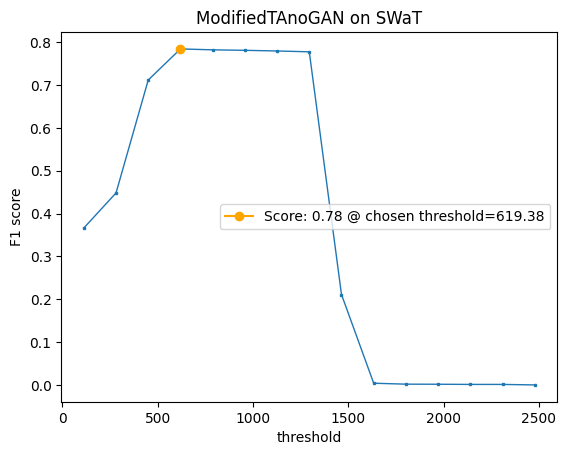


Precision score:
112.2962417602539: 0.22431152897246115
281.32319477626254: 0.29833945917563665
450.35014779227123: 0.6964725962450218
619.3771008082799: 0.970622624963461
788.4040538242886: 0.9934381199450634
957.4310068402972: 0.9970760233918129
1126.457959856306: 0.9973741118319431
1295.4849128723145: 0.9973631146269583
1464.5118658883232: 0.9974895397489539
1633.538818904332: 1.0
1802.5657719203405: 1.0
1971.5927249363492: 1.0
2140.619677952358: 1.0
2309.6466309683665: 1.0
2478.673583984375: 1.0


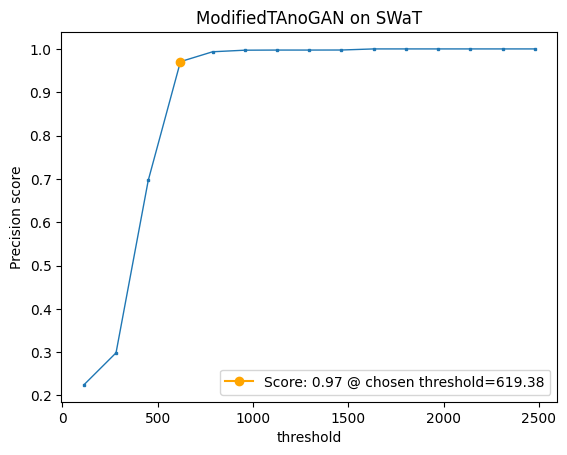


Recall score:
112.2962417602539: 1.0
281.32319477626254: 0.9008125247720967
450.35014779227123: 0.727804201347602
619.3771008082799: 0.6580459770114943
788.4040538242886: 0.6450653983353151
957.4310068402972: 0.6419936583432422
1126.457959856306: 0.6398137138327388
1295.4849128723145: 0.6371383273880301
1464.5118658883232: 0.11811335711454618
1633.538818904332: 0.002080856123662307
1802.5657719203405: 0.0009908838684106222
1971.5927249363492: 0.0008917954815695601
2140.619677952358: 0.0006936187078874356
2309.6466309683665: 0.0006936187078874356
2478.673583984375: 9.908838684106223e-05


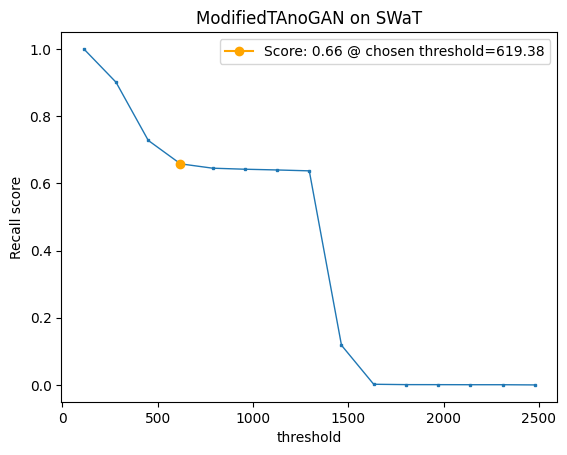

In [18]:
test_ground_truth = labels_attack

print("Test set metrics:")
compute_metrics(test_loss_array, test_ground_truth, "ModifiedTAnoGAN on SWaT", num_thresholds=15)

## ROC curve

In [19]:
def roc_plot(losses, labels, plot_title, num_thresholds=10):
  min_threshold = losses.min()
  max_threshold = losses.max()

  thresholds = np.linspace(start=min_threshold, stop=max_threshold, num=15)

  sens = list()
  fpr = list()
  for threshold in thresholds:
    predicted_labels = (losses >= threshold).astype(int)  # losses above threshold are predicted as anomaly

    matching = (predicted_labels == labels).astype(int)
    tp = matching[predicted_labels==1].astype(int).sum()

    cm_anomaly = np.zeros((2, 2))
    n_samples = len(losses)
    n_not_collisions = n_samples - sum(labels)
    n_detected = sum(predicted_labels)

    fp = n_detected - tp
    fn = sum(labels) - tp
    tn = n_not_collisions - fp

    sens.append(tp / (tp + fn))
    fpr.append(1-tn /(fp + tn))

  fig, ax = plt.subplots(1, 1)
  ax.plot(fpr, sens)
  plt.title(plot_title)

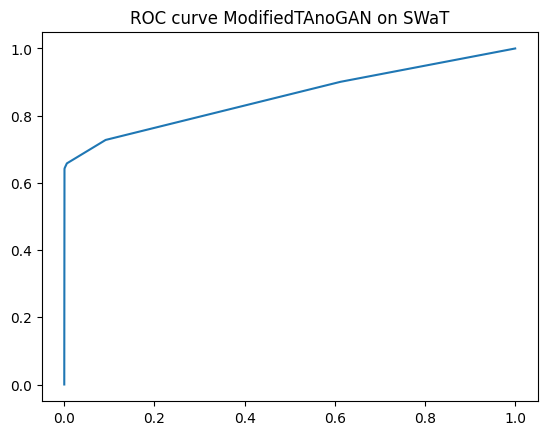

In [27]:
roc_plot(test_loss_array, test_ground_truth, "ROC curve ModifiedTAnoGAN on SWaT", 15)